In [16]:

import kagglehub

# Download latest version
path = kagglehub.dataset_download("rijulshr/pneumoniamnist")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pneumoniamnist


In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import f1_score
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, GaussianNoise, Input, Rescaling
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.callbacks import ModelCheckpoint

In [18]:
dataset = np.load(f"{path}/pneumoniamnist.npz")
dataset["train_images"].shape, dataset["train_labels"].shape

((3882, 28, 28), (3882, 1))

In [19]:
def normalization(image_set):
    min_val = np.min(image_set)
    max_val = np.max(image_set)
    difference = max_val - min_val
    return (image_set - min_val) / difference

In [20]:
xtrain = normalization(dataset["train_images"].reshape(-1, 28, 28, 1))
ytrain = dataset["train_labels"]

xvalid = normalization(dataset["val_images"].reshape(-1, 28, 28, 1))
yvalid = dataset["val_labels"]

xtest  = normalization(dataset["test_images"].reshape(-1, 28, 28, 1))
ytest = dataset["test_labels"]

Train Class Distribution:
Class 0: 388 samples
Class 1: 3494 samples

Validation Class Distribution:
Class 0: 135 samples
Class 1: 389 samples

Test Class Distribution:
Class 0: 234 samples
Class 1: 390 samples


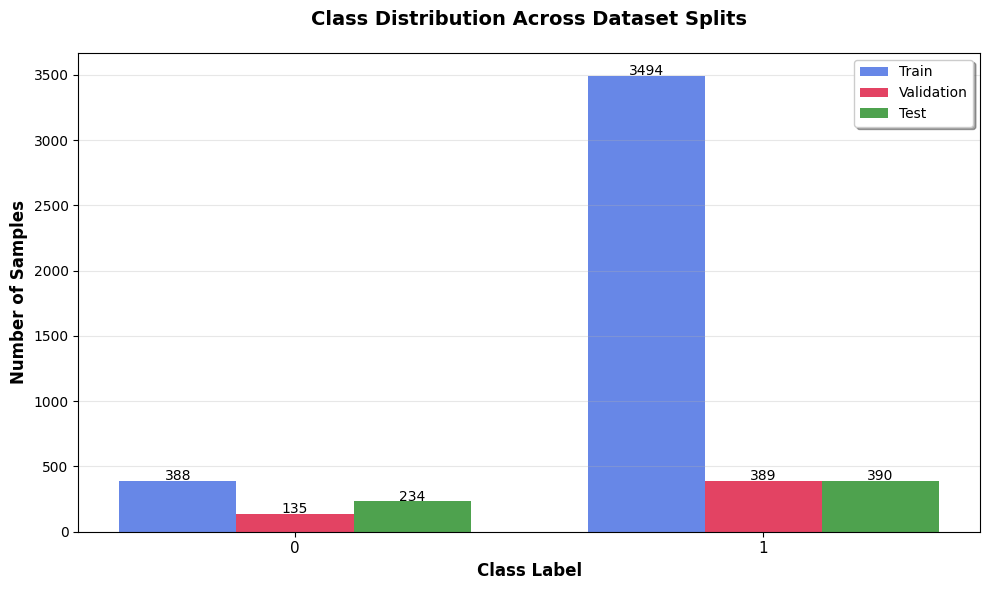

In [21]:
unique_train, counts_train = np.unique(ytrain, return_counts=True)
unique_val, counts_val = np.unique(yvalid, return_counts=True)
unique_test, counts_test = np.unique(ytest, return_counts=True)

# Print distribution
print("Train Class Distribution:")
for cls, count in zip(unique_train, counts_train):
    print(f"Class {cls}: {count} samples")

print("\nValidation Class Distribution:")
for cls, count in zip(unique_val, counts_val):
    print(f"Class {cls}: {count} samples")

print("\nTest Class Distribution:")
for cls, count in zip(unique_test, counts_test):
    print(f"Class {cls}: {count} samples")

# Optional: visualize imbalance
plt.figure(figsize=(10, 6))
bar_width = 0.25
x_pos = np.arange(len(unique_train))

plt.bar(x_pos - bar_width, counts_train, width=bar_width, color='royalblue', alpha=0.8, label='Train')
plt.bar(x_pos, counts_val, width=bar_width, color='crimson', alpha=0.8, label='Validation')
plt.bar(x_pos + bar_width, counts_test, width=bar_width, color='forestgreen', alpha=0.8, label='Test')

plt.xlabel("Class Label", fontsize=12, fontweight='bold')
plt.ylabel("Number of Samples", fontsize=12, fontweight='bold')
plt.xticks(x_pos, unique_train, fontsize=11)
plt.title("Class Distribution Across Dataset Splits", fontsize=14, pad=20, fontweight='bold')

# Add value labels on top of bars
for i, v in enumerate(counts_train):
    plt.text(i - bar_width, v + 5, str(v), color='black', ha='center')
for i, v in enumerate(counts_val):
    plt.text(i, v + 5, str(v), color='black', ha='center')
for i, v in enumerate(counts_test):
    plt.text(i + bar_width, v + 5, str(v), color='black', ha='center')

plt.legend(framealpha=1, shadow=True)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [22]:
data_augmentation = Sequential([
    Input(shape=(28, 28, 1)),
    RandomFlip("horizontal"),
    RandomRotation(0.1),                    # Rotate by ±10%
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1),
    GaussianNoise(0.1),                     # Add noise
])

AUTOTUNE = tf.data.AUTOTUNE

# Convert to tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
train_ds = train_ds.shuffle(buffer_size=1024).map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(64).prefetch(AUTOTUNE)

# Validation and test datasets (without augmentation)
val_ds = tf.data.Dataset.from_tensor_slices((xvalid, yvalid)).batch(64).prefetch(AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((xtest, ytest)).batch(64).prefetch(AUTOTUNE)


In [23]:
input_shape = (28, 28, 1)
input_layer = Input(shape=input_shape)

x = Concatenate()([input_layer, input_layer, input_layer])

# Load base model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=x)
base_model.trainable = False

weight_reg = L2(1e-4)   # L2 for weights
bias_reg = L1(1e-6)     # L1 for biases

# Modified model head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu',
          kernel_regularizer=weight_reg,
          bias_regularizer=bias_reg)(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid',
               kernel_regularizer=weight_reg,
               bias_regularizer=bias_reg)(x)

model = Model(inputs=input_layer, outputs=output)

model.summary()



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 28, 28, 3) │          0 │ input_layer_3[0]… │
│ (Concatenate)       │                   │            │ input_layer_3[0]… │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 34, 34, 3) │          0 │ concatenate_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 14, 14,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 14, 14,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 14, 14,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 16, 16,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 7, 7, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 7, 7, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 7, 7, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 7, 7, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 7, 7, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 7, 7, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 7, 7, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 7, 7, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 7, 7, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [24]:
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # avoid log(0)
        bce = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        loss = alpha_factor * modulating_factor * bce
        return tf.reduce_mean(loss)
    return focal_loss

class BalancedAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='balanced_accuracy', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.tn = self.add_weight(name='tn', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        tp = tf.reduce_sum(y_true * y_pred)
        tn = tf.reduce_sum((1 - y_true) * (1 - y_pred))
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))

        self.tp.assign_add(tp)
        self.tn.assign_add(tn)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        recall = self.tp / (self.tp + self.fn + 1e-7)
        specificity = self.tn / (self.tn + self.fp + 1e-7)
        return (recall + specificity) / 2

    def reset_states(self):
        self.tp.assign(0)
        self.tn.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)



class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + 1e-7)
        recall = self.true_positives / (self.true_positives + self.false_negatives + 1e-7)
        return 2 * (precision * recall) / (precision + recall + 1e-7)

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)



In [25]:
checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/best_model.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Callback to restore best weights after training
restore_best_weights = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)


In [26]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,      # number of steps after which decay is applied
    decay_rate=0.96,        # decay rate
    staircase=True          # if True, learning rate decays in discrete steps
)


model.compile(
    tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=binary_focal_loss(gamma=2.0, alpha=0.25),
    metrics=[
        BalancedAccuracy(name='balanced_accuracy'),
        tf.keras.metrics.AUC(name='auc'),
        F1Score(name='f1_score')  # instance of the class
    ]
)
history = model.fit(
    xtrain, ytrain,
    validation_data=(xvalid, yvalid),
    epochs=1000,
    verbose=1,
    callbacks=[checkpoint, restore_best_weights]
)

Epoch 1/1000
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.5632 - balanced_accuracy: 0.5354 - f1_score: 0.8451 - loss: 0.0907
Epoch 1: val_loss improved from inf to 0.06013, saving model to /kaggle/working/best_model.weights.h5
122/122 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - auc: 0.5640 - balanced_accuracy: 0.5357 - f1_score: 0.8454 - loss: 0.0905 - val_auc: 0.9362 - val_balanced_accuracy: 0.6491 - val_f1_score: 0.8868 - val_loss: 0.0601
Epoch 2/1000
117/122 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8045 - balanced_accuracy: 0.6760 - f1_score: 0.9278 - loss: 0.0371 
Epoch 2: val_loss improved from 0.06013 to 0.04819, saving model to /kaggle/working/best_model.weights.h5
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - auc: 0.8046 - balanced_accuracy: 0.6765 - f1_score: 0.9278 - loss: 0.0371 - val_auc: 0.9434 - val_balanced_accuracy: 0.7316 - val_f1_score: 0.9056 - val_loss: 0.0482
Epoch 3/1000
120/122 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8637 - balanced_accuracy: 0.7194 - f1_score:

In [27]:
for layer in base_model.layers[-20:]:  # fine-tune last 20 layers
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Recompile with a lower learning rate
fine_tune_lr = 1e-5
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr),
    loss=binary_focal_loss(gamma=2.0, alpha=0.25),
    metrics=[
        BalancedAccuracy(name='balanced_accuracy'),
        tf.keras.metrics.AUC(name='auc'),
        F1Score(name='f1_score')
    ]
)

In [28]:




fine_tune_history = model.fit(
    xtrain, ytrain,
    validation_data=(xvalid, yvalid),
    epochs=30,
    callbacks=[checkpoint, restore_best_weights],
    verbose=1
)


Epoch 1/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - auc: 0.9036 - balanced_accuracy: 0.7988 - f1_score: 0.9489 - loss: 0.0271
Epoch 1: val_loss did not improve from 0.02847
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 121ms/step - auc: 0.9037 - balanced_accuracy: 0.7988 - f1_score: 0.9489 - loss: 0.0271 - val_auc: 0.9573 - val_balanced_accuracy: 0.8337 - val_f1_score: 0.9300 - val_loss: 0.0375
Epoch 2/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9216 - balanced_accuracy: 0.8055 - f1_score: 0.9442 - loss: 0.0257
Epoch 2: val_loss did not improve from 0.02847
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - auc: 0.9215 - balanced_accuracy: 0.8055 - f1_score: 0.9442 - loss: 0.0257 - val_auc: 0.9592 - val_balanced_accuracy: 0.8521 - val_f1_score: 0.9330 - val_loss: 0.0358
Epoch 3/30
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9086 - balanced_accuracy: 0.8108 - f1_score: 0.9424 - loss: 0.0269
Epoch 3: val_loss did not improve from 0.02847
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0


📊 Final Test Set Performance:
Test Loss: 0.0638
Test Balanced Accuracy: 0.8308
Test AUC: 0.9329
Test F1-Score: 0.8932


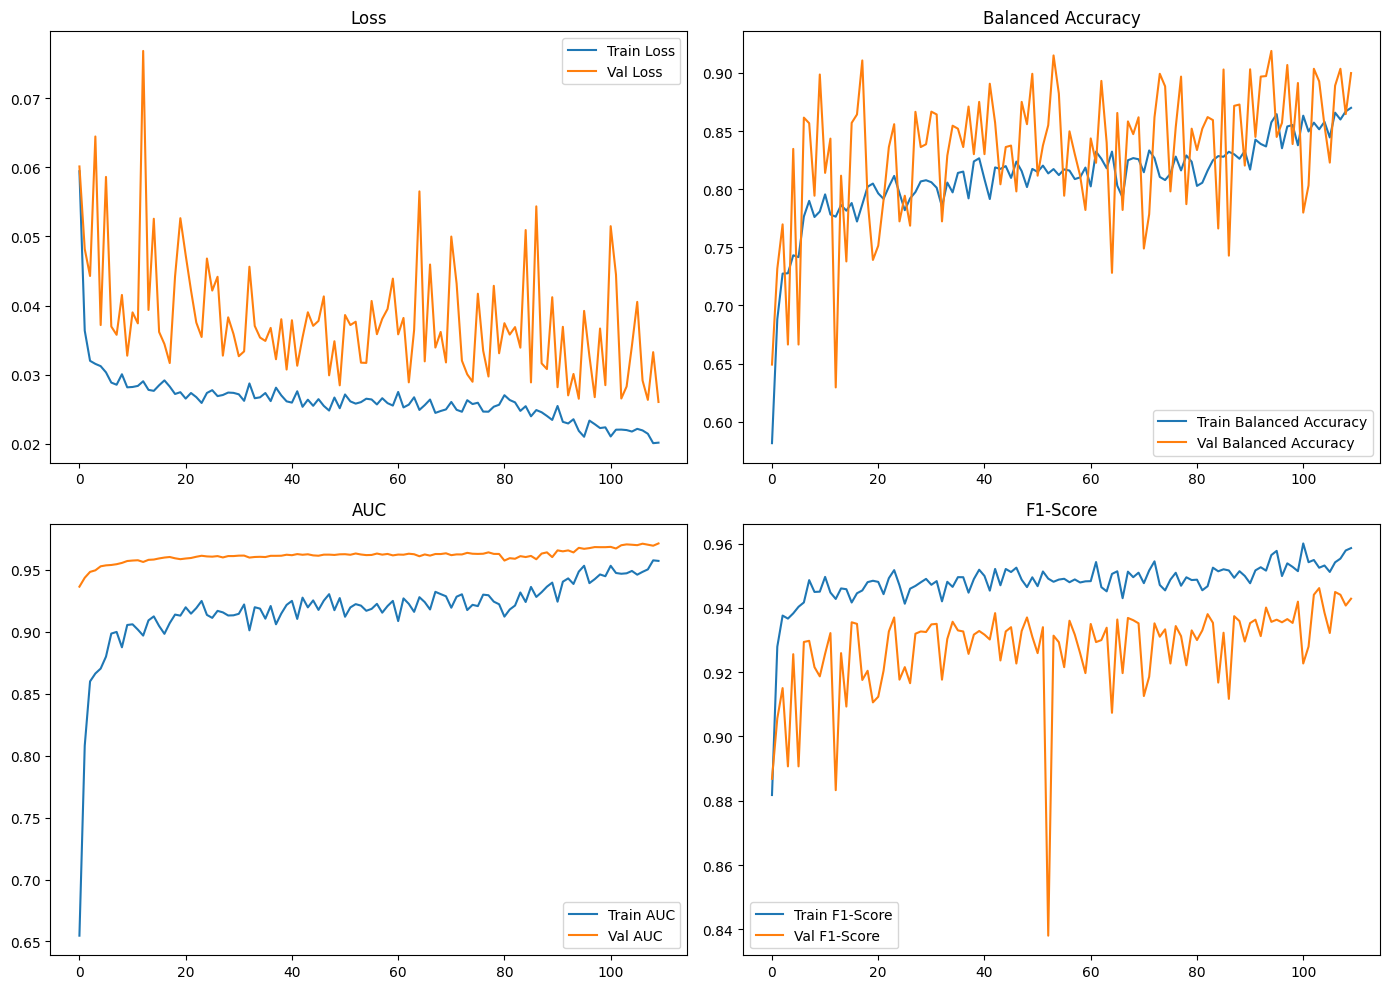

In [29]:
import matplotlib.pyplot as plt

# 1️⃣ Combine both histories
def combine_histories(history1, history2):
    combined = {}
    for key in history1.history:
        combined[key] = history1.history[key] + history2.history.get(key, [])
    return combined

# 2️⃣ Plotting function (unchanged)
def plot_metrics(history_dict):
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.plot(history_dict['loss'], label='Train Loss')
    plt.plot(history_dict['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(2, 2, 2)
    plt.plot(history_dict['balanced_accuracy'], label='Train Balanced Accuracy')
    plt.plot(history_dict['val_balanced_accuracy'], label='Val Balanced Accuracy')
    plt.legend()
    plt.title('Balanced Accuracy')

    plt.subplot(2, 2, 3)
    plt.plot(history_dict['auc'], label='Train AUC')
    plt.plot(history_dict['val_auc'], label='Val AUC')
    plt.legend()
    plt.title('AUC')

    plt.subplot(2, 2, 4)
    plt.plot(history_dict['f1_score'], label='Train F1-Score')
    plt.plot(history_dict['val_f1_score'], label='Val F1-Score')
    plt.legend()
    plt.title('F1-Score')

    plt.tight_layout()
    plt.show()

# 3️⃣ Evaluate final model on test set
test_metrics = model.evaluate(xtest, ytest, verbose=0)
print("\n📊 Final Test Set Performance:")
print(f"Test Loss: {test_metrics[0]:.4f}")
print(f"Test Balanced Accuracy: {test_metrics[1]:.4f}")
print(f"Test AUC: {test_metrics[2]:.4f}")
print(f"Test F1-Score: {test_metrics[3]:.4f}")

# 4️⃣ Plot merged training history
full_history = combine_histories(history, fine_tune_history)
plot_metrics(full_history)


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step


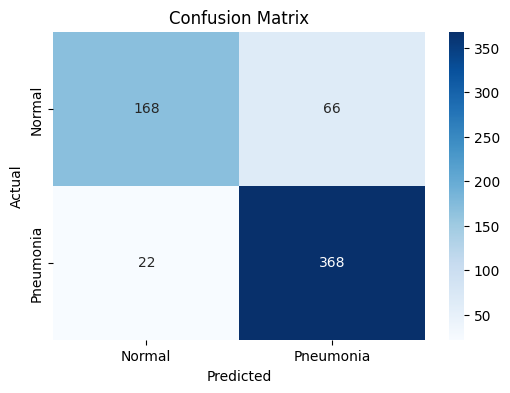

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
y_probs = model.predict(xtest)
y_pred = (y_probs > 0.5).astype(int).flatten()
report = classification_report(ytest, y_pred, target_names=["Normal", "Pneumonia"])
cm = confusion_matrix(ytest, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()